In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as tfms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# based on code from https://www.youtube.com/watch?v=OljTVUVzPpM&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=2&t=635s

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            # nn.Linear(in_features, 128),
            nn.Linear(in_features, 256),
            nn.LeakyReLU(0.01),
            # nn.Linear(128, 1),
            nn.Linear(256, 256),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x.float())

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, map_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            # nn.Linear(256, map_dim),
            nn.Linear(256, 256),
            nn.Linear(256, map_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [5]:
# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-5
z_dim = 128
# z_dim = 128
map_dim = 400 * 400 * 1 # 16000
# batch_size = 5
batch_size = 10
num_epochs = 50

In [6]:
print(device)

cuda


In [7]:
disc = Discriminator(map_dim).to(device)
gen = Generator(z_dim, map_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = tfms.Compose(
    [tfms.ToTensor(), tfms.Normalize((0.5,), (0.5,)),] # modify training data by normalizng to a desired mean and std deviation
)

In [8]:
# Need to override __init__, __len__, __getitem__
# as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path, transform=None, shape = (100,100)):
        print("Loading paths dataset...")
        # Read in path files
        # Convert to x by y np arrays
        # add the np arrays to a list
        # set self.transform and self.data
        self.paths = [] # create a list to hold all paths read from file
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                
                # xvales which to interpolate on
                # want to interpolate on xvalues from the min xval in the path to the largest xval in the path
                self.xvals = np.linspace(int(min(self.path[:,0])), int(max(self.path[:,0])), int(max(self.path[:,0])-min(self.path[:,0])))
                self.xvals = self.xvals.astype(int)

                # interpolate for all xvals using the paths from file's x and y values
                self.interp_path = np.interp(self.xvals, self.path[:,0], self.path[:,1])
                self.interp_path = np.array(self.interp_path).astype(int)

                # create a LxW matrix where all the values where path is equal to 1
                self.path_matrix = np.zeros(shape)
                self.path_matrix[self.interp_path, self.xvals] = 1
                

                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # print("getitem")
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # imagePath = self.paths_file + "/" + self.data['Image_path'][idx]
        # image = sk.imread(imagePath)
        # label = self.data['Condition'][idx]
        # image = Image.fromarray(image)

        # if self.sourceTransform:
        #     image = self.sourceTransform(image)
        x = self.paths[idx]

        if self.transform:
            x = self.transform(x)

        return x

        #return image, label




In [9]:
dataset = PathsDataset(path = "./data/map_20x20/", shape = (400,400), transform=None)

Loading paths dataset...
Done!


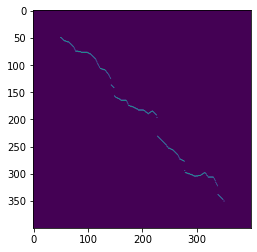

In [10]:
plt.imshow(dataset[20])

In [11]:
print(dataset[5])
print(len(dataset))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
10000


In [12]:
disc = Discriminator(map_dim).to(device)
gen = Generator(z_dim, map_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [13]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

In [14]:
for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        real = real.view(-1, 160000).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 400, 400)
                data = real.reshape(-1, 1, 400, 400)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Fake Generated Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Real Generated Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1000                       Loss D: 0.6934, loss G: 0.8038
Epoch [1/50] Batch 0/1000                       Loss D: 0.3437, loss G: 2.6946
Epoch [2/50] Batch 0/1000                       Loss D: 0.1748, loss G: 4.4885
